# LIDAR Basic Tests

## Objective

To evaluate Garmin's LIDAR Lite V4 suitability for the project by testing its ability to measure various distances under different lighting conditions.

## Experiment Details

### Experiment Setup

- **Sensor Positioning**: At regular 0.5m intervals ranging from 0.5m to 5.0m, with the sensor directed at a wall.
- **Test Environments**: Indoors, outdoors, and outdoors with a 3D-printed shade.
- **Data Collection**: Each test generated approximately 500 distance measurement points.

### Data Extraction

- **Indoors & Outdoors**: Utilized WaveShare's official software to transfer data into Excel files.

## Data Structure and Cleanup

- **File Organization**: Each distance interval (e.g., 0.5m, 1.0m, etc.) stores its measurements in a separate file located in their respective folders.
- **WaveShare Software**: I extract distance values from the Excel files generated by the software.
- **Raspberry Pi**: Every measurement from the Raspberry Pi includes time, distance and signal strength:

    ```text
    09:48:30 1030 659
    ```

- I keep the distances and filter out time and signal strength.

## Sensor Sepcification

- **Frequency**: Up to 200Hz.
- **Accuracy and Standard Deviation**:

||2m|4m|10m|
|---|---|---|---|
|Measurement|±1.0cm|±2.0cm|±5cm|

## Code Setup

### Imports

To maintain a clean and organized notebook, various functionalities have been distributed into separate Python modules:

- [`cleaner.py`](../src/data/cleaner.py) includes data cleaning functions.
- [`processing.py`](../src/data/processing.py) includes data processing functions.
- [`loader.py`](../src/data/loader.py) aids in extracting sensor data from text files.
- [`basic_graphs.py`](../src/graphing/basic_graphs.py) provides utilities for data visualization.

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

sys.path.append("../src")

from data import cleaner, processing
from data.loader import FolderData
from graphing import basic_graphs

### Data Preparation and Loading

I define the list of actual distances measured and load the data files.

In [2]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]

INDOORS_DATA_PATH = pathlib.Path("../data/processed/lidar_basic_tests/indoors/")
OUTDOORS_DATA_PATH = pathlib.Path("../data/processed/lidar_basic_tests/outdoors/")

indoors_data = FolderData(INDOORS_DATA_PATH)
outdoors_data = FolderData(OUTDOORS_DATA_PATH)

## Data Analysis

### Accuracy Assessment

- **Objective**: The sensor's accuracy is evaluated by comparing the mean measured distance to the actual distance at each interval.
- **Explanation**: Accuracy in our tests refers to how close our measurements are to the true values.
- **Analysis**: From the table below, we can see that the mean distance measured by the sensor at each interval, under both indoor and outdoor conditions, are nearly identical to that of the actual distance.

In [3]:
indoors_mean = processing.get_mean(indoors_data.distances)
outdoors_mean = processing.get_mean(outdoors_data.distances)

data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Outdoors Mean": outdoors_mean,
    "Indoors Mean": indoors_mean,
}
df = pd.DataFrame(data)
display(df.T)

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
Outdoors Mean,0.54,1.03,1.52,1.99,2.50,3.02,3.53,4.01,4.52,5.05
Indoors Mean,0.52,1.01,1.52,2.05,2.52,3.00,3.52,4.01,4.52,5.00


Visual representation suggests that the laser maintains accuracy across indoor and outdoor settings. In both indoor and outdoor environments, the laser's graph follows exactly that of the actual distance.

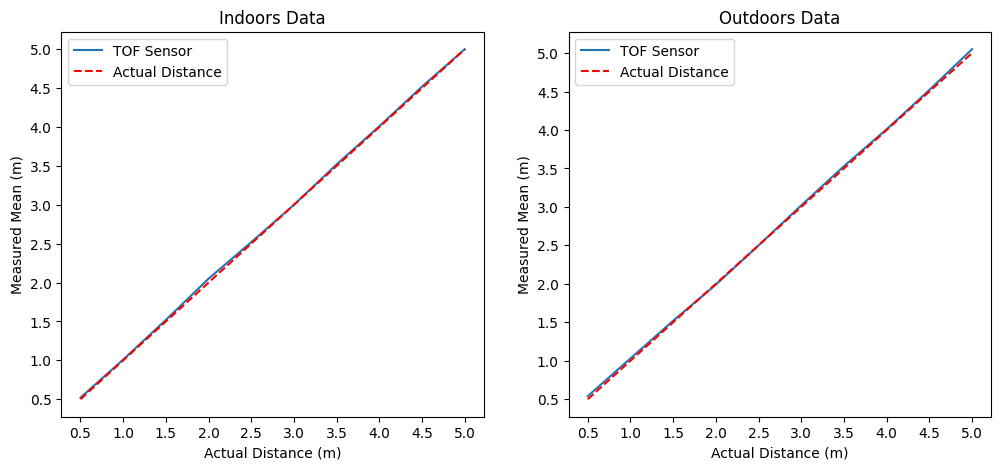

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
basic_graphs.plot_mean_vs_actual_distance(axes[0], indoors_mean, "Indoors Data")
basic_graphs.plot_mean_vs_actual_distance(axes[1], outdoors_mean, "Outdoors Data")
plt.show()

### Precision Assessment

- **Objective**: The sensor's precision is evaluated by plotting a scatter plot of the raw data and analyzing the spread of the points.
- **Explanation**: Precision in our tests refers to how close our measurements are to each other.
- **Analysis**: The LIDAR sensor appears to produce a few spurious points despite its average accuracy. However, the sensor remains relatively precise given how the bulk of the points are clustered about the actual distance being measured. It also appears that the sensor is slightly less precise outdoors given the greater number of spurious points.

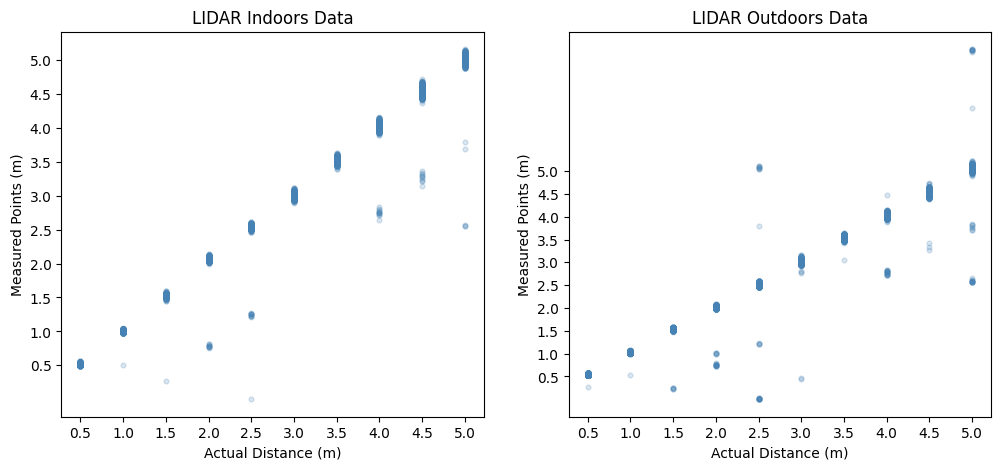

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
basic_graphs.plot_scatter(axes[0], indoors_data.distances, "LIDAR Indoors Data")
basic_graphs.plot_scatter(axes[1], outdoors_data.distances, "LIDAR Outdoors Data")
plt.show()

### Reliability Assessment: Standard Deviation

- **Objective**: Visualize the consistency of the laser sensor compared to the TOF sensor in each environment via standard deviation.
- **Explanation**: The standard deviation provides a measure of the spread of our measurements. In our context, a smaller standard deviation indicates that our measurements are tightly packed around the average value, hinting at both accuracy and precision.
- **Analysis**: In both indoors and outdoors the LIDAR sensor's standard deviation appears small, again implying that it is relatively reliable.

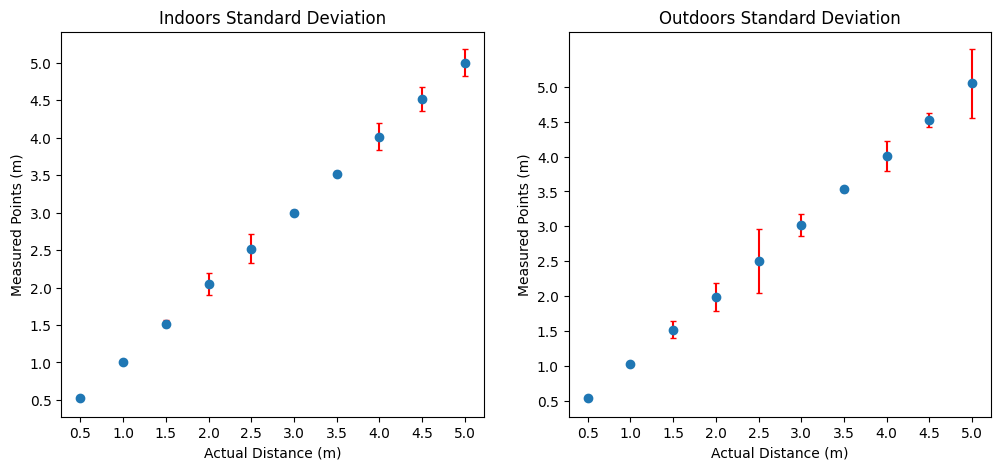

In [6]:
indoors_std = processing.get_std(indoors_data.distances)
outdoors_std = processing.get_std(outdoors_data.distances)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
basic_graphs.plot_std_errorbar(axes[0], indoors_mean, indoors_std, "Indoors Standard Deviation")
basic_graphs.plot_std_errorbar(axes[1], outdoors_mean, outdoors_std, "Outdoors Standard Deviation")
plt.show()

### Reliability Assessment: Best Fit Line

- **Objective**: Compare the line of best fit for each dataset to gauge the sensor's reliability.
- **Explanation**: The best fit line provides a visual representation of the correlation between measured values and actual values. A slope close to 1 implies a direct, proportional relationship.
- **Data Cleaning**: However, the prevalence of spurious data could compromise the curve's accuracy. To enhance this, one approach is data preprocessing—specifically, discarding data points exceeding one standard deviation from the mean.

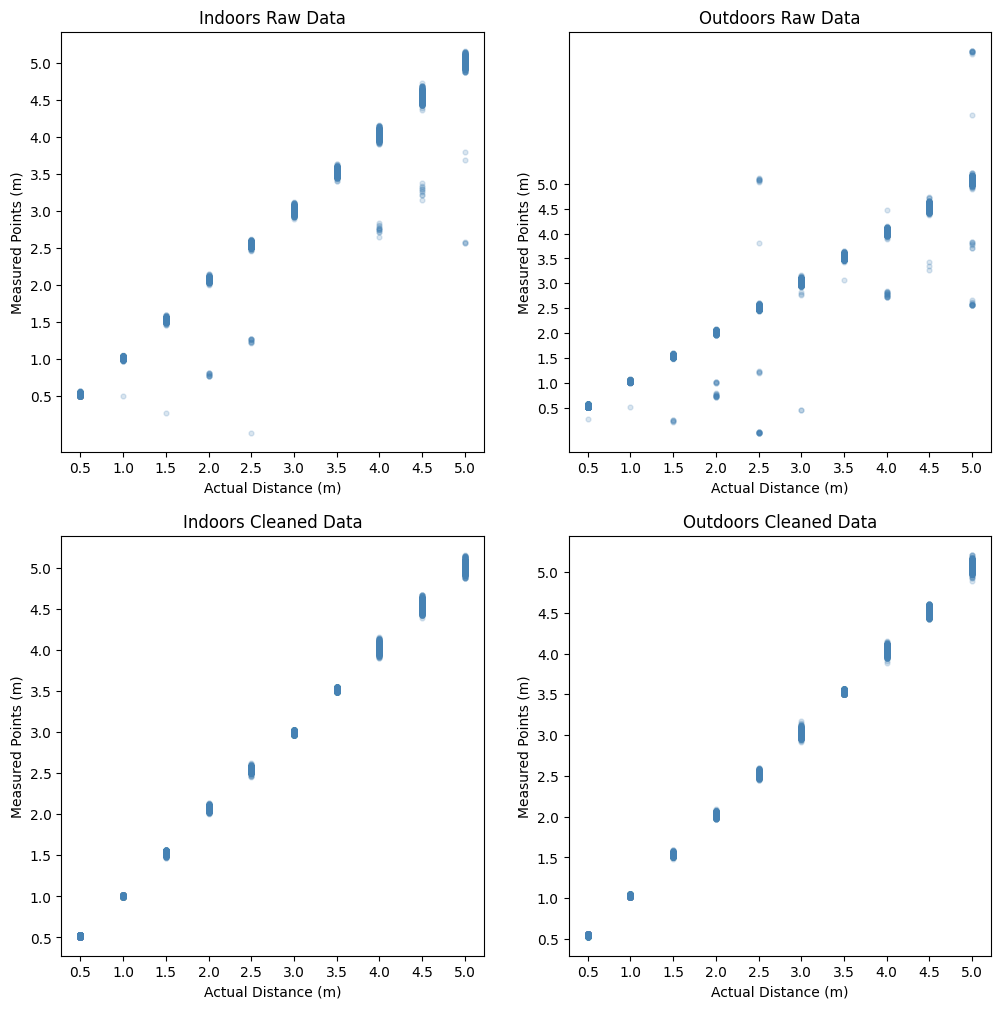

In [7]:
indoors_cleaned = cleaner.clean_basic_test_data(indoors_data.distances)
outdoors_cleaned = cleaner.clean_basic_test_data(outdoors_data.distances)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

basic_graphs.plot_scatter(axes[0][0], indoors_data.distances, "Indoors Raw Data")
basic_graphs.plot_scatter(axes[0][1], outdoors_data.distances, "Outdoors Raw Data")

basic_graphs.plot_scatter(axes[1][0], indoors_cleaned, "Indoors Cleaned Data")
basic_graphs.plot_scatter(axes[1][1], outdoors_cleaned, "Outdoors Cleaned Data")
plt.show()

- **Analysis**: From the best-fit lines drawn, it is shown that the data cleaning algorithm's improvement was neglibigle. For both indoors and outdoors data, the equation of the best-fit line both before and after cleaning remained very close to $y=x$, indicating that the sensor was very reliable at all distance intervals. This also suggests that the spurious points depicted in the graphs above were negligible and should not have a large impace on the sensor's performance.

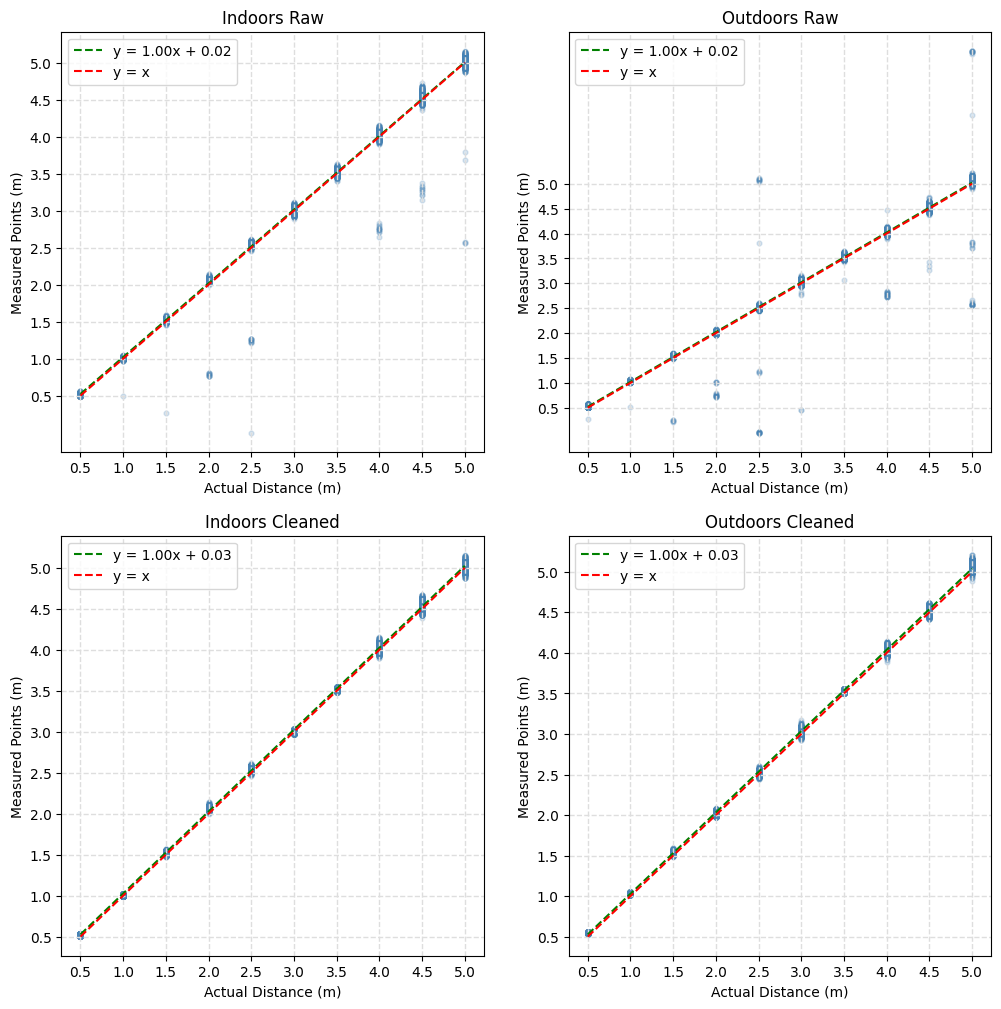

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

basic_graphs.plot_best_fit_scatter(axes[0][0], indoors_data.distances, "Indoors Raw")
basic_graphs.plot_best_fit_scatter(axes[0][1], outdoors_data.distances, "Outdoors Raw")

basic_graphs.plot_best_fit_scatter(axes[1][0], indoors_cleaned, "Indoors Cleaned")
basic_graphs.plot_best_fit_scatter(axes[1][1], outdoors_cleaned, "Outdoors Cleaned")

plt.show()

## Conclusion

## Conclusion

Throughout our analysis, my findings highlight Garmin's LIDAR-Lite V4's behavior under varying conditions:

1. **Accuracy**: The LIDAR sensor showcased impressive accuracy both indoors and outdoors, with measurements mirroring the true values up to 5.0m.
2. **Precision**: The sensor generated spurious data in both indoors and outdoors conditions. However, the bulk of the points were clustered at the true values.
3. **Standard Deviation**: The standard deviation of the points measured appeared small and unimpactful to the reliability of the sensor.
4. **Best Fit Line**: With or without cleaning the data, in both indoors and outdoors, the best fit line for the data is almost $y=x$. This suggests that the LIDAR sensor is not only reliable under daylight, but the spurious data that it generates is negligible.

Therefore, the LIDAR sensor is strong candidate to be used to measure the passing distance of vehicles, given its reliability and high rate of data sampling of 200Hz.